# 背景
有 n 句话，每句话都由且仅由 3 个单词组成。要做的是，将每句话的前两个单词作为输入，最后一词作为输出，训练一个 RNN 模型


# 导包

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

dtype = torch.FloatTensor

# 准备数据

In [2]:
sentences = [ "i like dog", "i love coffee", "i hate milk"]

word_list = " ".join(sentences).split()
vocab = list(set(word_list))
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for i, w in enumerate(vocab)}
n_class = len(vocab)

# 预处理数据
构建 Dataset，定义 DataLoader，输入数据用 one-hot 编码

In [3]:
# TextRNN Parameter
batch_size = 2
# n_step = 2 # number of cells(= number of Step) # 输入是2个单词，所以两步
n_hidden = 5 # number of hidden units in one cell

def make_data(sentences):
    input_batch = []
    target_batch = []

    for sen in sentences:
        word = sen.split()
        input = [word2idx[n] for n in word[:-1]]
        target = word2idx[word[-1]]

        input_batch.append(np.eye(n_class)[input])
        target_batch.append(target)

    return input_batch, target_batch

input_batch, target_batch = make_data(sentences)
input_batch, target_batch = torch.Tensor(input_batch), torch.LongTensor(target_batch)
dataset = Data.TensorDataset(input_batch, target_batch)
loader = Data.DataLoader(dataset, batch_size, True)

# 定义网络架构

以上代码每一步都值得说一下，首先是 nn.RNN(input_size, hidden_size) 的两个参数，input_size 表示每个词的编码维度，由于我是用的 one-hot 编码，而不是 WordEmbedding，所以 input_size 就等于词库的大小 len(vocab)，即 n_class。然后是 hidden_size，这个参数没有固定的要求，你想将输入数据的维度转为多少维，就设定多少

对于通常的神经网络来说，输入数据的第一个维度一般都是 batch_size。而 PyTorch 中 nn.RNN() 要求将 batch_size 放在第二个维度上，所以需要使用 x.transpose(0, 1) 将输入数据的第一个维度和第二个维度互换

然后是 rnn 的输出，rnn 会返回两个结果，即上面代码的 out 和 hidden，关于这两个变量的区别，我在之前的博客也提到过了，如果不清楚，可以看我上面提到的 RNN Layer 这篇博客。这里简单说就是，out 指的是下图的红框框起来的所有值；hidden 指的是下图蓝框框起来的所有值。我们需要的是最后时刻的最后一层输出，即 y3 的值，所以使用 out=out[-1] 将其获取

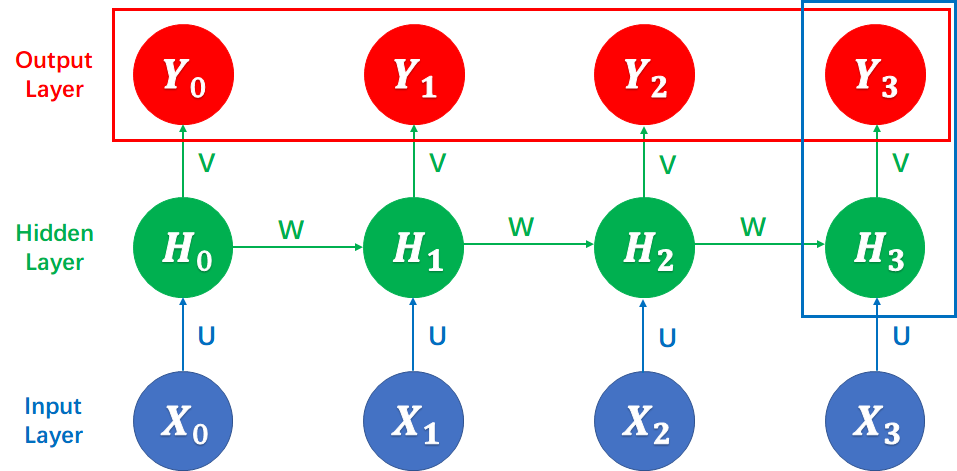

In [4]:
class TextRNN(nn.Module):
    def __init__(self):
        super(TextRNN, self).__init__()
        self.rnn = nn.RNN(input_size=n_class, hidden_size=n_hidden)
        # fc
        self.fc = nn.Linear(n_hidden, n_class)

    def forward(self, hidden, X):
        # X: [batch_size, n_step, n_class]
        X = X.transpose(0, 1) # X : [n_step, batch_size, n_class]
        out, hidden = self.rnn(X, hidden)
        # out : [n_step, batch_size, num_directions(=1) * n_hidden]
        # hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        out = out[-1] # [batch_size, num_directions(=1) * n_hidden] ⭐
        model = self.fc(out)
        return model

model = TextRNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练

In [5]:
# Training
for epoch in range(5000):
    for x, y in loader:
      # hidden : [num_layers * num_directions, batch, hidden_size]
      hidden = torch.zeros(1, x.shape[0], n_hidden) # 不能直接用batch_size因为最后一批大小可能不一样
      # x : [batch_size, n_step, n_class]
      pred = model(hidden, x)

      # pred : [batch_size, n_class], y : [batch_size] (LongTensor, not one-hot)
      loss = criterion(pred, y)
      if (epoch + 1) % 1000 == 0:
          print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

Epoch: 1000 cost = 0.036839
Epoch: 1000 cost = 0.045057
Epoch: 2000 cost = 0.007034
Epoch: 2000 cost = 0.008571
Epoch: 3000 cost = 0.002655
Epoch: 3000 cost = 0.001556
Epoch: 4000 cost = 0.000916
Epoch: 4000 cost = 0.000536
Epoch: 5000 cost = 0.000332
Epoch: 5000 cost = 0.000192


# 测试

In [6]:
input = [sen.split()[:2] for sen in sentences]
# Predict
hidden = torch.zeros(1, len(input), n_hidden)
predict = model(hidden, input_batch).data.max(1, keepdim=True)[1]
print([sen.split()[:2] for sen in sentences], '->', [idx2word[n.item()] for n in predict.squeeze()])

[['i', 'like'], ['i', 'love'], ['i', 'hate']] -> ['dog', 'coffee', 'milk']
